# MobileNet Grading of Diabetic Retinopathy in PyTorch

In [74]:
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.



In [75]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['Train', 'Val', 'Test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['Test'], batch_size=32,
                                        shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(image_datasets['Test'], batch_size=32,
                                        shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



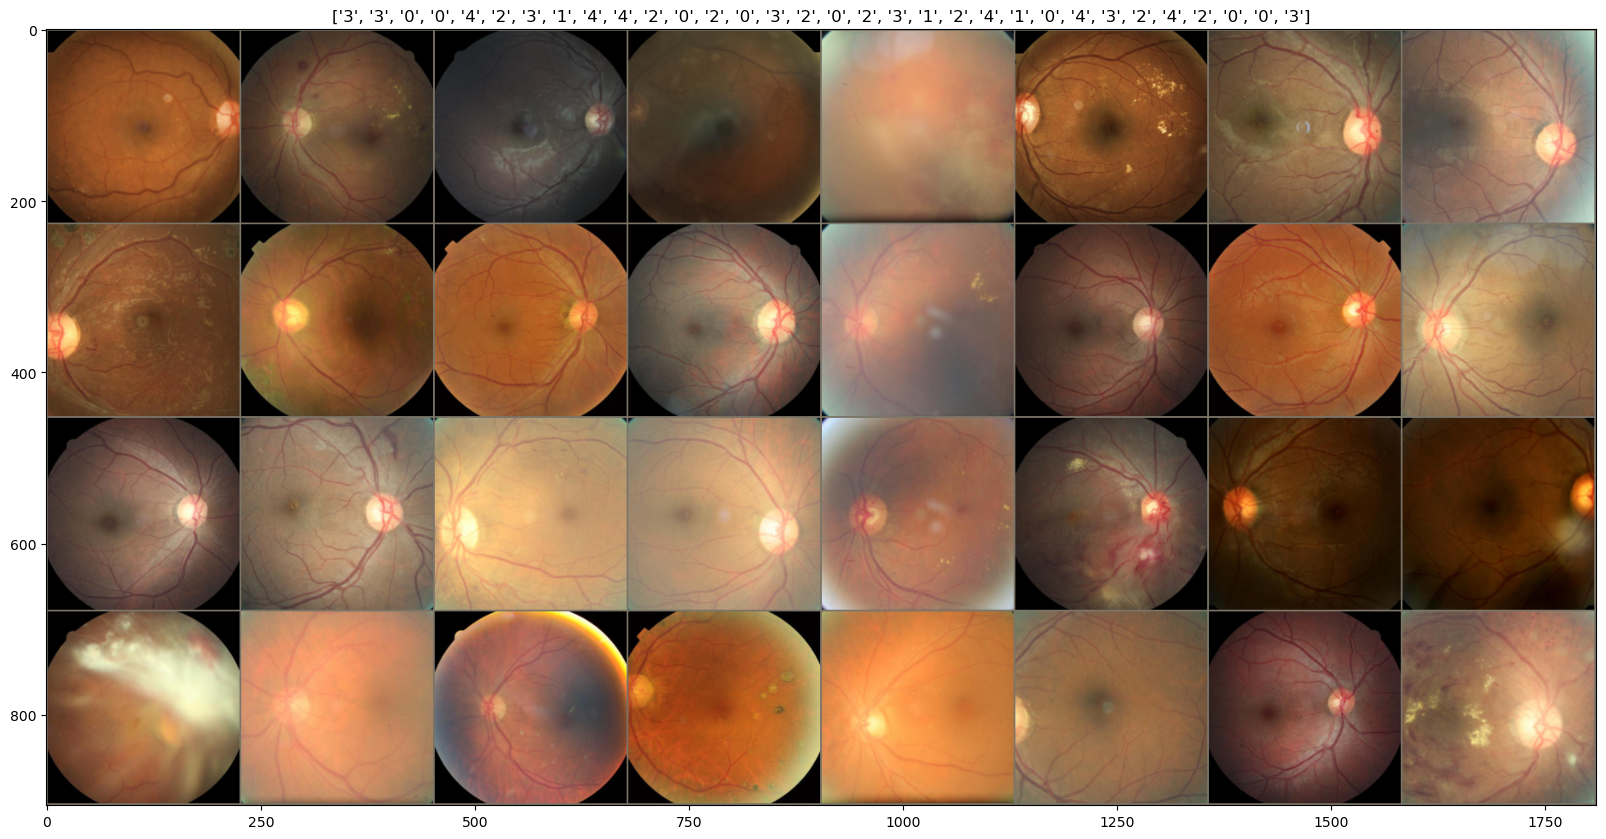

In [76]:
def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [77]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [78]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [79]:
import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')

model_weights = models.MobileNet_V3_Large_Weights.DEFAULT
model_ft = models.mobilenet_v3_large(weights=model_weights)
num_ftrs = model_ft.classifier[-1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[-1] = nn.Linear(num_ftrs, 5)

warmup_epochs = 5
training_epochs = 25
FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


display(model_ft)

MobileNet_V3_Large_Weights.IMAGENET1K_V2_5_25_Grading_02_Apr_23_00_20


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### Train and evaluate




Warm-up

In [80]:
for param in model_ft.features.parameters():
    param.requires_grad = False

In [81]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=warmup_epochs)

Epoch 0/4
----------
Train Loss: 1.5910 Acc: 0.2494
Val Loss: 1.5462 Acc: 0.3181

Epoch 1/4
----------
Train Loss: 1.4902 Acc: 0.3718
Val Loss: 1.4647 Acc: 0.3905

Epoch 2/4
----------
Train Loss: 1.4294 Acc: 0.4163
Val Loss: 1.4131 Acc: 0.3962

Epoch 3/4
----------
Train Loss: 1.3913 Acc: 0.4245
Val Loss: 1.3779 Acc: 0.4038

Epoch 4/4
----------
Train Loss: 1.3487 Acc: 0.4416
Val Loss: 1.3528 Acc: 0.4095

Training complete in 4m 19s
Best val Acc: 0.409524


Training

In [82]:
for param in model_ft.features.parameters():
    param.requires_grad = True

In [83]:
MODEL_PATH = os.path.sep.join(['models', f'{FILENAME}.pt'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=training_epochs)
torch.save(model_ft.state_dict(), MODEL_PATH)

Epoch 0/24
----------
Train Loss: 1.2944 Acc: 0.4653
Val Loss: 1.2922 Acc: 0.4267

Epoch 1/24
----------
Train Loss: 1.2047 Acc: 0.4865
Val Loss: 1.2217 Acc: 0.4438

Epoch 2/24
----------
Train Loss: 1.1381 Acc: 0.5376
Val Loss: 1.2120 Acc: 0.4590

Epoch 3/24
----------
Train Loss: 1.1227 Acc: 0.5469
Val Loss: 1.2032 Acc: 0.4629

Epoch 4/24
----------
Train Loss: 1.1168 Acc: 0.5543
Val Loss: 1.1933 Acc: 0.4705

Epoch 5/24
----------
Train Loss: 1.1009 Acc: 0.5478
Val Loss: 1.1883 Acc: 0.4705

Epoch 6/24
----------
Train Loss: 1.0891 Acc: 0.5539
Val Loss: 1.1821 Acc: 0.4781

Epoch 7/24
----------
Train Loss: 1.0765 Acc: 0.5629
Val Loss: 1.1790 Acc: 0.4781

Epoch 8/24
----------
Train Loss: 1.0657 Acc: 0.5620
Val Loss: 1.1728 Acc: 0.4952

Epoch 9/24
----------
Train Loss: 1.0573 Acc: 0.5735
Val Loss: 1.1714 Acc: 0.4952

Epoch 10/24
----------
Train Loss: 1.0613 Acc: 0.5731
Val Loss: 1.1709 Acc: 0.4971

Epoch 11/24
----------
Train Loss: 1.0553 Acc: 0.5686
Val Loss: 1.1710 Acc: 0.4895

Ep

Visualization

<Figure size 640x480 with 0 Axes>

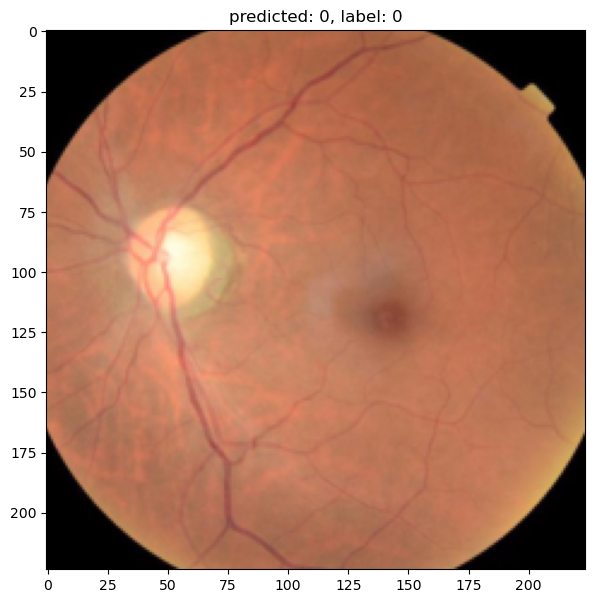

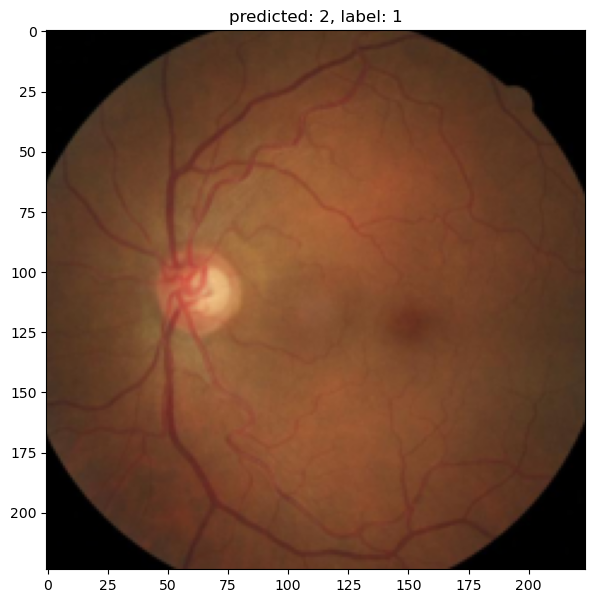

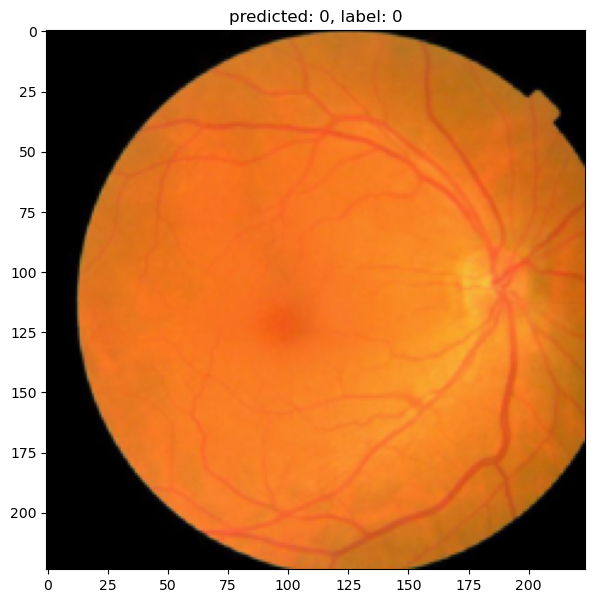

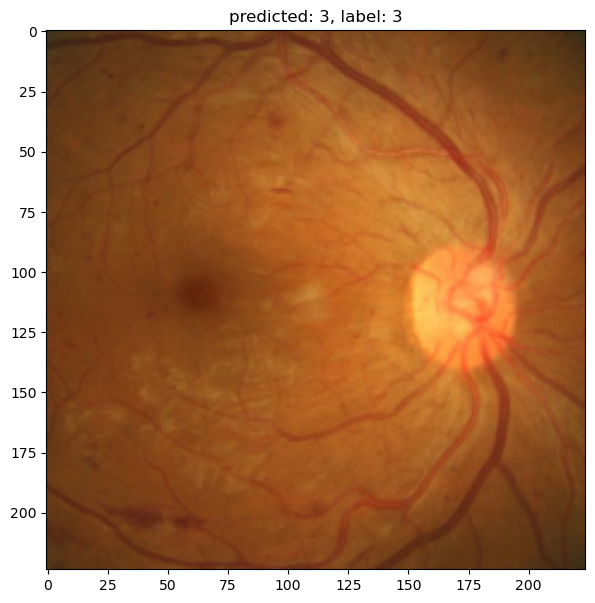

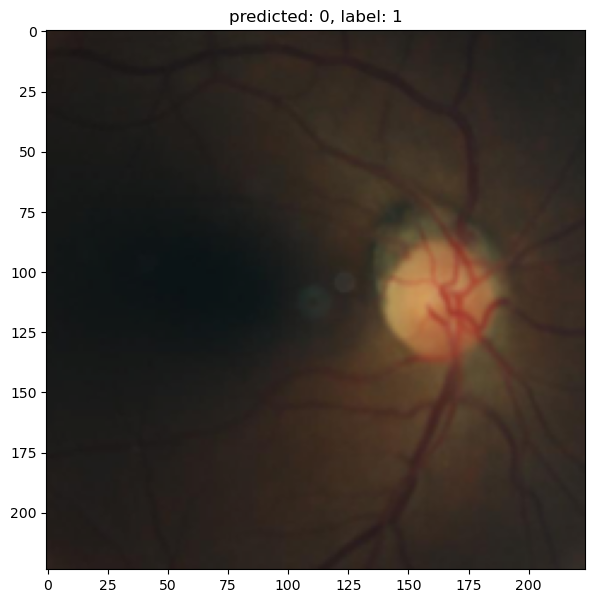

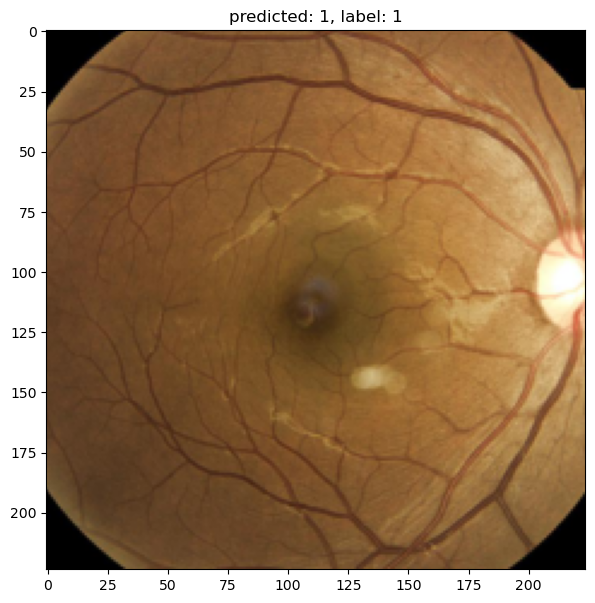

In [84]:
visualize_model(model_ft)

In [85]:
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

model_ft.eval()

for inputs, labels in test_dataloader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")

[INFO] Iterating predictions
[INFO] Finished iterating predictions


[INFO] Building Matrix


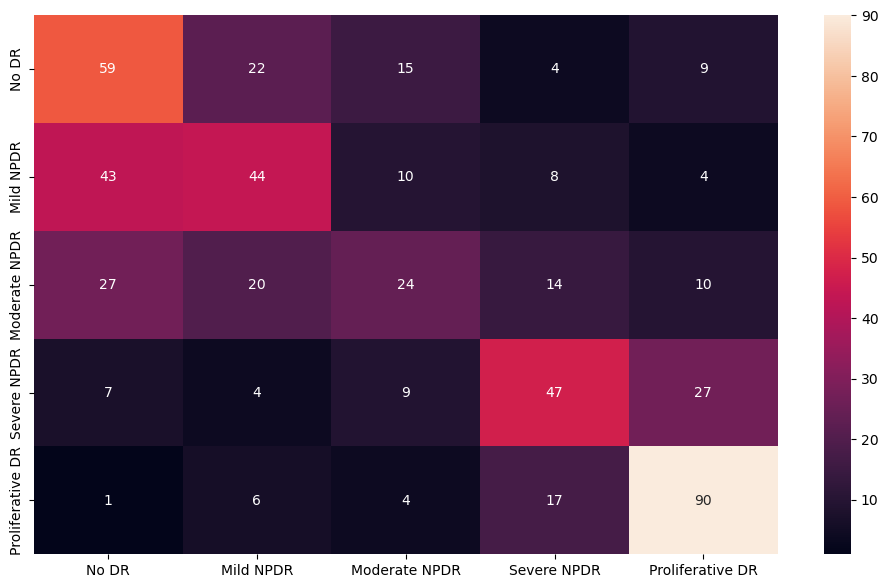

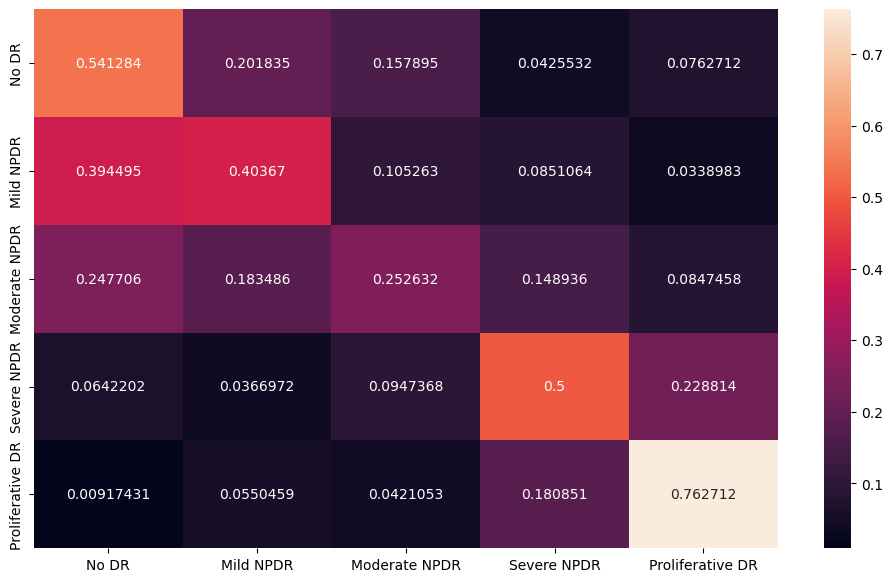

In [86]:
print("[INFO] Building Matrix")
# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)